# PyWR

Load libraries

In [6]:
import xarray as xr
import numpy as np
import pandas as pd
#import eccodes
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy import interpolate
import string
# key PyWR functions are imported here
from PyWR import *

In [7]:
# Spatial domain
nla=55 	# Northernmost latitude
sla=0 	# Southernmost latitude
wlo=-125 	# Westernmost longitude
elo=-40 	# Easternmost longitude
#Time domain:
season='Jan-Dec'
yeari=1985
yeare=2005
#Indicate if force download all data (True in case it's corrupted or new one is needed)
force=True

# Prepare Data (if needed)

This section downloads data (as needed; details below).

First, let's create a `data` and a `figs` folder. If already there, it won't create anything.

In [8]:
!mkdir -p NAm
!cd Ecuador
!mkdir -p NAm/data
!mkdir -p NAm/figs

To download data from the IRI data library, you need an authentication key. This is stored in a file called `.IRIDLAUTH`, but is not part of the GitHub repository -- you need to contact the IRI Data Library to request access. Once you have done so, you can put your own authentication key in a file called `.IRIDLAUTH` and use this code. This is a moderately annoying step, and we apologize, but it is required by the S2S Database Terms and Conditions and is necessary for us to share all our code while maintaining some security.

**NB** if you're using `git`, be sure to add `.IRIDLAUTH` to your `gitignore` file :)

In [9]:
with open('data/.IRIDLAUTH') as file:
   authkey = file.read() 

## Reanalysis and obs data

Here we download all the data needed, using the spatial and temporal domains defined above. We download the physical field used to build the weather types (geopotential height anomalies at 500 mb in this case), winds (500 mb), rainfall and temperature fields. A 5-day moving average is applied to the fields before computing the daily anomalies (daily climatologies are computed via the naïve approach).

Important: some of the datasets are huge. If the data is already downloaded and ok (e.g., not corrupted) but we wanted to re-download it, set `force_download=True` below (each dataset can be controlled independently).

In [10]:
reanalysis = download_data(
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.pressure_level_gh/.gh/P/500/VALUE/P/removeGRID/S/(3%20Sep%202017)/VALUE/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/hdate/(1997)/(2016)/RANGE/hdate//pointwidth/0/def/-6/shiftGRID/hdate/(days%20since%201960-01-01)/streamgridunitconvert/S/(days%20since%202019-01-01)/streamgridunitconvert/S//units//days/def/L/0.5/add/hdate/add/add//pointwidth/1/def/SOURCES/.ECMWF/.ERA-Interim/.SIX-HOURLY/.pressure_level/.z500/T/3/shiftGRID/T/24/boxAverage/T/2/index/.units/streamgridunitconvert/exch/%5BT%5Dsample-along/c%3A/9.81/(m%20s-2)/%3Ac/div/S/removeGRID/L/5/runningAverage/%5BX/Y%5D/1.0/0./regridLinear/dup/%5Bhdate%5Daverage/2/RECHUNK/sub/data.nc',
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.NASA/.NCCS_Dataserver/.CREATE_REANALYSIS/.MERRA2/.day/.atmos/.zg/plev/500/VALUE/plev/removeGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/-0.875/shiftGRID/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/data.nc',
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GSFC/.MERRA/.Anl_StdLev/.h500/T/1/boxAverage/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/5/runningAverage/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/dup/%5BT%5D/average/sub/data.nc',
    #url='http://iridl.ldeo.columbia.edu/home/.agmunoz/.NNRP/.chi_200/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.DAILY/.Intrinsic/.PressureLevel/.phi/P/(500)/VALUE/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/100/mul/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    outfile='NAm/data/hgt_NNRP_rean.nc', 
    authkey=authkey,
    force_download=force
).stack(time=['T'], grid=['Y', 'X'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.5M  100 23.5M    0     0   339k      0  0:01:11  0:01:11 --:--:-- 5314k  0    0     0    0     0      0      0 --:--:--  0:00:05 --:--:--     00    0     0    0     0      0      0 --:--:--  0:00:16 --:--:--     0    0 --:--:--  0:00:29 --:--:--     0 0     0    0     0      0      0 --:--:--  0:00:42 --:--:--     0    0    0     0    0     0      0      0 --:--:--  0:01:05 --:--:--     0


In [11]:
# uwnd = download_data(
#     #url='http://iridl.ldeo.columbia.edu/home/.agmunoz/.NNRP/.chi_200/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.DAILY/.Intrinsic/.PressureLevel/.u/%5BX/Y%5D/regridAverage/T/(days%20since%201960-01-01%2000%3A00%3A00)/streamgridunitconvert/P/(500)/VALUE/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
#     url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.DAILY/.Intrinsic/.PressureLevel/.u/P/(500)/VALUE/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
#     outfile='data/u_NNRP_rean.nc', 
#     authkey=authkey,
#     force_download=force
# ).stack(time=['T'], grid=['Y', 'X'])

In [12]:
# vwnd = download_data(
#     #url='http://iridl.ldeo.columbia.edu/home/.agmunoz/.NNRP/.chi_200/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.DAILY/.Intrinsic/.PressureLevel/.v/%5BX/Y%5D/regridAverage/T/(days%20since%201960-01-01%2000%3A00%3A00)/streamgridunitconvert/P/(500)/VALUE/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
#     url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.DAILY/.Intrinsic/.PressureLevel/.v/P/(500)/VALUE/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
#     outfile='data/v_NNRP_rean.nc', 
#     authkey=authkey,
#     force_download=force
# ).stack(time=['T'], grid=['Y', 'X'])

In [13]:
rainfall = download_data(
    url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/%28%201%20Jan%20'+str(yeari)+'%29/%2830%20Dec%20'+str(yeare)+'%29/RANGEEDGES/T//pointwidth/0/def/0./shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/5/runningAverage/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/-0.5/shiftGRID/data.nc',
    outfile='NAm/data/rainfall_cpc.nc', 
    authkey=authkey,
    force_download=force
).stack(time=['T'], grid=['Y', 'X'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  563M  100  563M    0     0  7376k      0  0:01:18  0:01:18 --:--:-- 22.6M  0      0      0 --:--:--  0:00:12 --:--:--     0     0      0 --:--:--  0:00:31 --:--:--     00:18 22.3M


In [14]:
t2m  = download_data(
    url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmax/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmin/add/2/div/T/(days%20since%201960-01-01%2000%3A00%3A00)/streamgridunitconvert/T/%28%201%20Jan%20'+str(yeari)+'%29/%2830%20Dec%20'+str(yeare)+'%29/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmax/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmin/add/2/div/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/5/runningAverage/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/dup/T/to366daysample%5BYR%5Daverage/T/sampleDOY/sub/data.nc',
    outfile='NAm/data/t2m_cpc.nc', 
    authkey=authkey,
    force_download=force
).stack(time=['T'], grid=['Y', 'X'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  563M  100  563M    0     0  1024k      0  0:09:23  0:09:23 --:--:-- 25.0M 0:00:17 --:--:--     0   0     0      0      0 --:--:--  0:00:36 --:--:--     00:45 --:--:--     0    0     0      0      0 --:--:--  0:01:11 --:--:--     00    0     0    0     0      0      0 --:--:--  0:01:31 --:--:--     001:42 --:--:--     0-:--:--  0:01:50 --:--:--     0 0    0     0    0     0      0      0 --:--:--  0:02:01 --:--:--     0   0    0     0    0     0      0      0 --:--:--  0:02:03 --:--:--     0-  0:02:09 --:--:--     000      0      0 --:--:--  0:02:37 --:--:--     0  0     0    0     0      0      0 --:--:--  0:02:40 --:--:--     00    0     0      0      0 --:--:--  0:02:50 --:--:--     0   0 --:--:--  0:03:43 --:--:--     0    0    0     0    0     0      0      0 --:--:--  0:04:00 --:--:--     0    0      0 --:--:--  0:04:06 

In [15]:
reanalysis=reanalysis.isel(P=0)
#reanalysis=reanalysis.isel(aprod=0)
reanalysis

<xarray.Dataset>
Dimensions:  (grid: 805, time: 7666)
Coordinates:
    P        int32 500
  * time     (time) MultiIndex
  - T        (time) float64 9.134e+03 9.136e+03 9.136e+03 ... 1.68e+04 1.68e+04
  * grid     (grid) MultiIndex
  - Y        (grid) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 55.0 55.0 55.0 55.0 55.0
  - X        (grid) float64 -125.0 -122.5 -120.0 -117.5 ... -45.0 -42.5 -40.0
Data variables:
    adif     (time, grid) float32 -483.80948 -329.52377 ... 13669.522 12722.857

In [16]:
# uwnd=uwnd.isel(P=0) #getting rid of the dummy pressure coordinate
# uwnd

In [17]:
# vwnd=vwnd.isel(P=0) #getting rid of the dummy pressure coordinate
# vwnd

In [18]:
rainfall

<xarray.Dataset>
Dimensions:  (grid: 19264, time: 7666)
Coordinates:
  * time     (time) MultiIndex
  - T        (time) float64 9.134e+03 9.136e+03 9.136e+03 ... 1.68e+04 1.68e+04
  * grid     (grid) MultiIndex
  - Y        (grid) float64 -0.25 -0.25 -0.25 -0.25 ... 55.25 55.25 55.25 55.25
  - X        (grid) float64 -125.2 -124.8 -124.2 -123.8 ... -40.75 -40.25 -39.75
Data variables:
    adif     (time, grid) float32 nan nan nan nan nan ... nan nan nan nan nan

In [19]:
t2m

<xarray.Dataset>
Dimensions:  (grid: 19264, time: 7665)
Coordinates:
  * time     (time) MultiIndex
  - T        (time) float64 9.134e+03 9.136e+03 9.136e+03 ... 1.68e+04 1.68e+04
  * grid     (grid) MultiIndex
  - Y        (grid) float64 -0.25 -0.25 -0.25 -0.25 ... 55.25 55.25 55.25 55.25
  - X        (grid) float64 -125.2 -124.8 -124.2 -123.8 ... -40.75 -40.25 -39.75
Data variables:
    asum     (time, grid) float32 nan nan nan nan nan ... nan nan nan nan nan

# Dimension Reduction

We need to choose a percentage of variance explained that we will require:

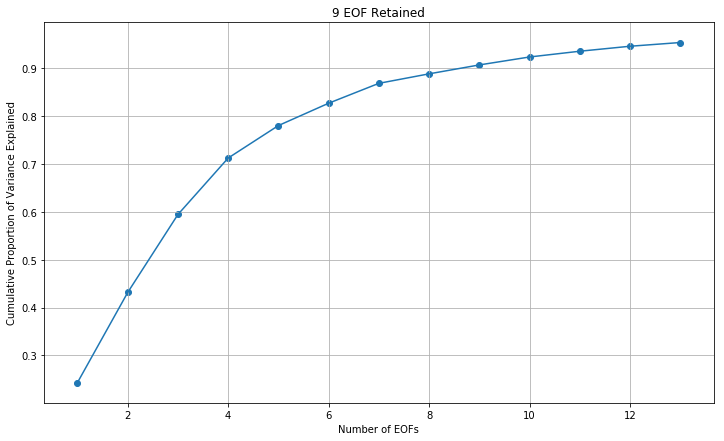

In [20]:
n_eof = get_number_eof(X=reanalysis['adif'].values, var_to_explain=0.9, plot=True)

Now we project the data onto the leading EOFs to get the principal component time series.
We will retain the PCA model for use later.
The `reanalysis_pc` variable is now indexed [`time`, `EOF`].

In [21]:
pca_model = PCA(n_components=n_eof).fit(reanalysis['adif'].values)
reanalysis_pc = pca_model.transform(reanalysis['adif'].values)

# Reanalysis Weather Typing

Now we perform the clustering.
We will manually specify the number of clusters we want to create and the number of simulations we want to run.

In [22]:
ncluster = 6 # use 6 WTs
n_sim = 50 # typically 25-50 -- try 25 for quick preliminary computation only

Now we can use this to run the classifiability index on our centroids

In [23]:
centroids, wtypes = loop_kmeans(X=reanalysis_pc, n_cluster=ncluster, n_sim=n_sim)
class_idx, best_part = get_classifiability_index(centroids)
#print('The classifiability index is {}'.format(class_idx))

In [24]:
#Let's reorder the WTs such that the most frequent is WT1, and the less frequent is WT_last
best_wt = wtypes[best_part, :]
best_wt = pd.Series(resort_labels(best_wt), index=reanalysis["time"]).to_xarray()
best_wt.name = "wtype"

Now that we have identified a suitable partition, we can use it to keep only the corresponding centroid and set of weather type labels.
To take advantage of the scikit-learn syntax, we then use these centroids to define a `KMeans` object.

In [25]:
best_fit = KMeans(n_clusters=ncluster, init=centroids[best_part, :, :], n_init=1, max_iter=1).fit(reanalysis_pc)

In [26]:
# start with reanalysis
reanalysis_composite = reanalysis.copy()
#model_clust = best_fit.fit_predict(reanalysis_pc) # get centroids
weather_types = xr.DataArray(
    #model_clust, 
    best_wt,
    coords = {'time': reanalysis_composite['time']},
    dims='time'
)
reanalysis_composite['WT'] = weather_types
reanalysis_composite = reanalysis_composite.groupby('WT').mean(dim='time').unstack('grid')['adif']
reanalysis_composite['M'] = 0

In [27]:
wt_anomalies = [] # initialize empty list
wt_anomalies.append(reanalysis_composite)

wt_anomalies = xr.concat(wt_anomalies, dim='M') # join together
#wt_anomalies['WT'] = wt_anomalies['WT'] # start from 1

Plot as a function of WT and ensemble member.
Note `M=0` for reanalysis

In [28]:
# plt.rcParams.update({'font.size': 12})

# p = wt_anomalies.plot.contourf(
#     x='X', y='Y', col='WT', row='M',
#     transform=ccrs.PlateCarree(),
#     subplot_kws={
#         'projection': ccrs.PlateCarree()#ccrs.Orthographic(-90, 0)
#         #ccrs.PlateCarree()
#     },
#     figsize=(10, 10),
#     levels = np.linspace(-400000, 400000, 11),
#     cmap=plt.cm.bwr,
#     extend='both'
# )

# xmin,xmax = wt_anomalies['X'].min(), wt_anomalies['X'].max()
# ymin,ymax = wt_anomalies['Y'].min(), wt_anomalies['Y'].max()
# for ax in p.axes.flat:
#     ax.coastlines()
#     ax.add_feature(feature.BORDERS)
#     ax.set_extent([xmin, xmax, ymin, ymax])

# plt.show()

Now, let's prepare a figure with rainfall and temperature composites

In [29]:
X, Y = np.meshgrid(reanalysis['adif'].X, reanalysis['adif'].Y)
map_proj = ccrs.PlateCarree() #ccrs.Orthographic(-110, 10)
data_proj = ccrs.PlateCarree()
wt_unique = np.unique(wt_anomalies['WT'])
figsize = (14, 8)
#plot_region = Region(lon = [wlo, elo], lat = [sla, nla])

In [30]:
#WT proportions
wt=weather_types.to_dataframe(name='WT')
wt=wt
#wt.to_netcdf('data/Klee.nc', format="NETCDF4")
wt_counts = wt.groupby('WT').size().div(wt['WT'].size)
wt_counts

WT
1    0.206496
2    0.196582
3    0.180798
4    0.149491
5    0.143752
6    0.122880
dtype: float64

/Users/agmunoz/miniconda3/envs/iri-dev/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


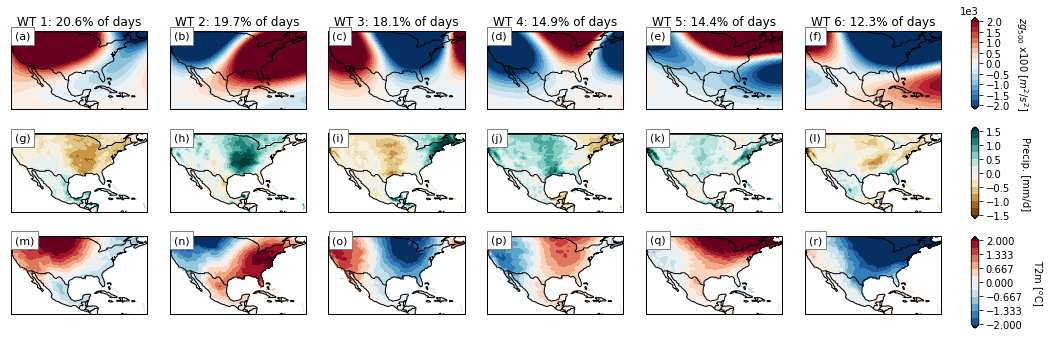

In [31]:
xmin,xmax = reanalysis['X'].min(), reanalysis['X'].max()
ymin,ymax = reanalysis['Y'].min(), reanalysis['Y'].max()

# Set up the Figure
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(
        nrows=3, ncols=len(wt_unique), subplot_kw={'projection': map_proj}, 
        figsize=figsize, sharex=True, sharey=True
    )

# Loop through
for i,w in enumerate(wt_unique):
    def selector(ds):
        times = wt.loc[wt['WT'] == w].index
        ds = ds.sel(time = np.in1d(ds.unstack('time')['T'], times))
        ds = ds.mean(dim = 'time')
        return(ds)

    # Top row: geopotential height anomalies
    ax = axes[0, i]
    ax.set_title('WT {}: {:.1%} of days'.format(w, wt_counts.values[i]))
    C0 = selector(reanalysis['adif']).unstack('grid').plot.contourf(
        transform = data_proj,
        ax=ax,
        cmap='RdBu_r',
        extend="both",
        #levels=np.linspace(-8e6, 8e6, 21),
        levels=np.linspace(-2e3, 2e3,17),
        add_colorbar=False,
        add_labels=False
    )
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    ax.set_extent([xmin, -60, 12, 45])

    # add wind arrows
#     U = selector(uwnd).adif.values  
#     V = selector(vwnd).adif.values
#     magnitude = np.sqrt(U**2 + V**2)
#     strongest = magnitude > np.percentile(magnitude, 50)
#     Q = ax.streamplot(X,Y,U,V,density=1)
#     Q = ax.quiver(
#         X[strongest], Y[strongest], U[strongest], V[strongest], 
#         transform=data_proj, 
#         width=0.01, scale=1.,units='xy'
#     )

    # Middle row: rainfall anomalies
    ax = axes[1, i]
    C1 = selector(rainfall['adif']).unstack('grid').plot.contourf(
        transform = data_proj,
        ax=ax,
        cmap = 'BrBG',
        extend="both",
        levels=np.linspace(-1.5, 1.5, 13),
        add_colorbar=False,
        add_labels=False
    )
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    #ax.set_extent([-95, -75, -9, 5])
    ax.set_extent([xmin, -60, 12, 45])

    # Bottom row: tepmperature anomalies
    ax = axes[2, i]
    C2 = selector(t2m['asum']).unstack('grid').plot.contourf(
        transform = data_proj,
        ax=ax,
        cmap = 'RdBu_r',
        extend="both",
        levels=np.linspace(-2., 2., 13),
        add_colorbar=False,
        add_labels=False
    )
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    #ax.set_extent([-95, -75, -9, 5])
    ax.set_extent([xmin, -60, 12, 45])
    ax.tick_params(colors='b')

# # Add Colorbar
plt.tight_layout()
fig.subplots_adjust(right=0.94,bottom=0.4)
cax0 = fig.add_axes([0.97, 0.80, 0.0075, 0.16])
cax1 = fig.add_axes([0.97, 0.61, 0.0075, 0.16])
cax2 = fig.add_axes([0.97, 0.42, 0.0075, 0.16])
cbar0 = fig.colorbar(C0, cax = cax0)
cbar0.formatter.set_powerlimits((2, 2))
cbar0.update_ticks()
#cbar0.set_label(r'$\xi_{200}$ anomaly [$m^2$/s]', rotation=270)
cbar0.set_label(r'$zg_{500}$ x100 [$m^2$/$s^2$]', rotation=270)
cbar0.ax.get_yaxis().labelpad = 20
cbar1 = fig.colorbar(C1, cax=cax1)
cbar1.set_label('Precip. [mm/d]', rotation=270)
cbar1.ax.get_yaxis().labelpad = 20
cbar2 = fig.colorbar(C2, cax=cax2)
cbar2.set_label('T2m [$^o$C]', rotation=270)
cbar2.ax.get_yaxis().labelpad = 20

# Format these axes


#Add plot labels
letters = string.ascii_lowercase
for i, ax in enumerate(axes.flat):
   label = '({})'.format(letters[i])
   t = ax.text(0.03, 0.899, label, fontsize=11, transform=ax.transAxes)
   t.set_bbox(dict(facecolor='white', edgecolor='gray'))

# Add a quiver key
#k = plt.quiverkey(Q, 0.9, 0.7, 1, '1 m/s', labelpos='E', coordinates='figure')

fig.savefig('NAm/figs/wt_composite.pdf', bbox_inches='tight')
plt.show()

In [32]:
#wt_anomalies

In [33]:
attrs = {"units": "days since 1960-01-01"}
wttime = xr.Dataset({"time": ("time", weather_types.unstack().coords['T'], attrs)})
ds = xr.Dataset({"time": ("time", [0, 1, 2, 3], attrs)})

In [34]:
xr.decode_cf(wttime)

<xarray.Dataset>
Dimensions:  (time: 7666)
Coordinates:
  * time     (time) datetime64[ns] 1985-01-03T12:00:00 ... 2005-12-29T12:00:00
Data variables:
    *empty*

In [35]:
wt['year']=xr.decode_cf(wttime).time.dt.year.values
wt['doy'] = wt.groupby('year').transform(lambda x: np.arange(x.size))['WT']+1

In [36]:
wt_prop = wt.groupby(['year', 'WT']).size().to_xarray()
wt_prop = wt_prop / wt_prop.sum(dim='WT')
wt_prop = wt_prop.to_pandas()*100

In [37]:
wt_propsubs = wt.groupby(['doy', 'WT']).size().to_xarray()
wt_propsubs = wt_propsubs / wt_propsubs.sum(dim='WT')
wt_propsubs = wt_propsubs.to_pandas()*100
for ii in range(ncluster):
    interpolate.InterpolatedUnivariateSpline(wt_propsubs.index, wt_propsubs[ii+1])

In [38]:
Klee = wt.set_index(['doy', 'year']).to_xarray()['WT']

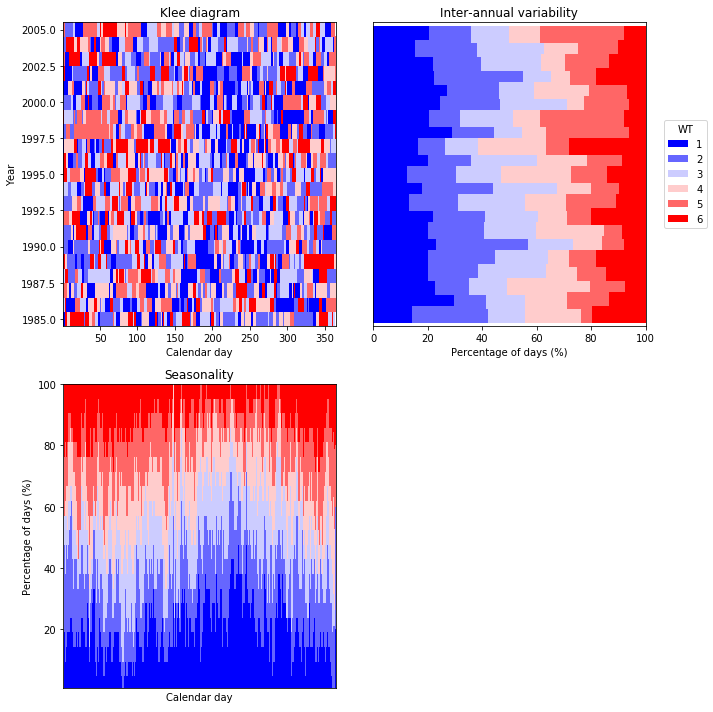

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax = axes[0,0]
Klee.plot(x='doy', y='year', ax=ax, add_colorbar=False,cmap='bwr')
ax.set_xlabel('Calendar day')
ax.set_ylabel('Year')
ax.set_title('Klee diagram')
ax.set_xlim([1, 365])
ax = axes[0,1]
wt_prop.plot.barh(stacked=True, cmap='bwr', ax=ax, width=1.2)
ax.set_xlabel('Percentage of days (%)')
ax.set_ylabel('')
ax.set_yticks([])
ax.set_xlim([0, 100])
ax.set_title('Inter-annual variability')
ax.legend(title='WT',bbox_to_anchor=(1.05, .5), loc='center left')
ax = axes[1,0]
#wt_propsubs.plot(cmap='bwr', ax=ax)
wt_propsubs.plot.bar(stacked=True, cmap='bwr', ax=ax, width=1.2)
ax.set_ylabel('Percentage of days (%)')
ax.set_xlabel('Calendar day')
ax.get_legend().remove()
ax.set_ylim([1, 100])
#start, end = ax.get_xlim()
ax.set_xticks([])
#ax.xaxis.set_ticks(np.arange(start, end, 50))
#ax.set_yticks([])
ax.set_title('Seasonality')
axes[-1, -1].axis('off')
fig.tight_layout()
fig.savefig('NAm/figs/klee.pdf', bbox_inches='tight')
plt.show()